# Data Prep & Sliding Window 
For this notebook, we will take our **datastore.csv** file created with **notebooks 1&2** and we will further process & apply a *sliding window* approach to labeling our data. 

Given this data is on time-series nature, we must keep it's time-series integrity intact. 

To do so, we will slide a **28-day window**, save that window as a **28x28** matrix with the label of the following days prediction. 

```python
if following_day_closing_price > 0:
    this_window_label = 'buy'
else:
    this_window_label = 'sell'
```

The reason we will classifiy on whether it's greater than **0** or not is simple because we calculated **Stationary close** and applied a **tanh** non-linear function. Thus giving us a range of {-1,1} 

So, if the following day has a positive change, it's a buy! Otherwise a sell as it performed bad. 

## Labeling 
Following after this, we will store all of our data within the **model_data** directory labeled in the following manner: 

eq. first image is a buy, second image is a buy, third image is a sell
```['1_1_B.tif', '2_2_B.tif', '3_1_S.tif']```

Thus to perform such labeling we will:
```python
img = f'{order_number}_{label_number}_{label}'
```

We do this so the images remain in order, though it's important to always double check before feeding the data through the model

## Following
Upon labeling all of our data (along with any other necessary preprocessing, we will move onto **notebook 4** which will utilize **FastAI's** Deep Learning framework! 

To run the next notebook we suggest using a VM with access to a GPU, otherwise a local GPU with GPU acceleration on

In [ ]:
# !pip install tqdm
# !pip install seaborn
# !pip install tifffile

In [204]:
from tqdm import tnrange
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tifffile import imsave
import tifffile

%matplotlib inline

In [205]:
# path to datastore
path = f'{os.curdir}/data/post_processing/datastore.csv'

In [206]:
# loading df
df = pd.read_csv(path,index_col=['time'])

In [207]:
df

,Stationary_Close,volume,RSI_15,RSI_20,RSI_25,RSI_30,SMA_15,SMA_20,SMA_25,SMA_30,...,William_R_22,Stoch_14,Stoch_18,Stoch_22,Ultimate_7_14_28,Ultimate_8_16_22,Ultimate_9_18_36,MFI_14,MFI_18,MFI_22
time,,,,,,,,,,,,,,,,,,,,,
2009-06-01 21:00:00,NaN,2.381802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-02 21:00:00,0.013399,2.207583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-03 21:00:00,-0.026114,2.898414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-04 21:00:00,-0.014149,2.420517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-05 21:00:00,-0.019398,1.918638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-07 21:00:00,-0.002500,-0.909661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-08 21:00:00,0.009510,1.686677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-09 21:00:00,0.025345,0.537803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-10 21:00:00,0.005490,0.787867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [232]:
# Removing NaN values, these result in skewed images which may result in mis-representation of real data for our model
f_df = df.copy()
f_df.dropna(inplace=True)

## Labeling & Saving
We will test with two different formats of saving. **.tif** & **.jpg** 

Considering the values we stores in our Dataframe are of float value, it is best to retain these values so we do not lose any information with any form of conversions. 

Thus for our initial test we will convert every window into a **.tif** file. 

In [233]:
# Labeling function
def labeling_data(df, path):
    """
    This function is reponsible for creating our dataset of images. This will create a 28x28 image with the label of the following day's projected
    
    df: dataframe to create images
    path: the path to save the file
    """
    start_index = 0
    end_index = 28 # this is the initialization value as we are using 28 day windows
    label_index = 29 # this is our initialization value so we begin at 29
    
    # initializing values for labeling images
    img_index = 1 
    buy_index = 1
    sell_index = 1
    
    # Looping through dataframe
    for i in tnrange(len(df), desc='Dataset %'):
        
        # since the division will be out of index, we will place everything in a try/catch block to avoid that nasty error from being display
        try: 
            # grabbing the window
            window_df = df.iloc[start_index:end_index]

            # Converting to numpy array - need this in order to convert to .tif
            window = np.array(window_df).astype(np.float32)

            # labelling
            if df.iloc[label_index]['Stationary_Close'] > 0:
                # saving a buy image
                label = 'B' # buy
                file_name = f'{img_index}_{buy_index}_{label}.tif'

                # Creating image
                tifffile.imsave(f'{path}/{file_name}',window)

                # counting up
                buy_index += 1
                img_index += 1

            else:
                # saving a sell image
                label = 'S' # sell
                file_name = f'{img_index}_{buy_index}_{label}.tif'

                # Creating image
                tifffile.imsave(f'{path}/{file_name}',window)

                # counting up
                sell_index += 1
                img_index += 1

            # Counting up - this will allow us to create the window-slide 
            start_index += 1
            end_index += 1
            label_index += 1
            
        # when it throws that error, this will pass it 
        except Exception:
            pass
        
    print('Finished!')

In [234]:
# Run this cell to create images with our data - .tif by default
save_path = f'{os.curdir}/data/model_data/images'
labeling_data(f_df, save_path)


Finished!


### Labeling CSVs & DFs
We will also provide two CSVs. One will be used for a tabular model, while the other will be simply used to help with labeling of the images from this image dataset

#### Labeling Tabular Model

In [236]:
# Let's also create a labeled csv file to go alone with this dataset - to be used for FastAI and tabular regression models

tabular_df = f_df.copy()

In [239]:
# Labeling 
tabular_df['label_test'] = ['Buy' if row > 0 else 'Sell' for row in tabular_df['Stationary_Close']]

In [242]:
# Checking
tabular_df.head(3)

,Stationary_Close,volume,RSI_15,RSI_20,RSI_25,RSI_30,SMA_15,SMA_20,SMA_25,SMA_30,...,Stoch_14,Stoch_18,Stoch_22,Ultimate_7_14_28,Ultimate_8_16_22,Ultimate_9_18_36,MFI_14,MFI_18,MFI_22,label_test
time,,,,,,,,,,,,,,,,,,,,,
2009-07-15 21:00:00,0.011519,0.197722,52.834161,51.477689,50.943272,50.611947,1.631811,1.635613,1.637061,1.637604,...,57.837980,57.837980,57.837980,64.472927,60.535401,62.950024,35.625156,44.212156,40.037300,Buy
2009-07-16 21:00:00,0.001460,0.312415,53.388169,51.881373,51.258513,50.872569,1.630956,1.635769,1.637483,1.637585,...,80.882876,59.758022,59.758022,67.517542,65.089750,61.511430,34.599574,44.138323,45.417399,Buy
2009-07-17 21:00:00,-0.010350,0.215660,49.015262,48.848759,48.936356,48.977202,1.630131,1.635602,1.636844,1.637241,...,67.951201,46.146765,46.146765,60.410414,62.258837,62.849541,35.038422,41.413389,46.298801,Sell


In [246]:
# Saving
path = f'{os.curdir}/data/tabular_models'
tabular_df.to_csv(f'{path}/tabular_1.csv')

#### Labeling Image Dataset

In [369]:
# Let's make a list of all image names
images_path = f'{os.curdir}/data/model_data/images'

# we will use this to create a DF, then join that with
images_list = os.listdir(images_path)

images_list.remove('.ipynb_checkpoints')

ValueError: list.remove(x): x not in list

In [367]:
images_label_df = pd.DataFrame(images_list,columns=['image_name'])
images_label_df['label'] = [i.split('_')[-1][0] for i in images_label_df['image_name']]
images_label_df['image_name'] = [i.split('.')[0] for i in images_label_df['image_name']] # removes .tif 
# images_label_df['idx'] = [int(i.split('_')[0]) for i in images_label_df['image_name'].values] # sorting index
# images_label_df.set_index('idx',inplace=True)
# images_label_df.sort_index(ascending=True,inplace=True)

In [368]:
images_label_df.head()

,image_name,label
0,images,i
1,image_labels,l


In [327]:
images_label_df['label'].value_counts()

S    1352
B    1250
Name: label, dtype: int64

In [330]:
# Saving
path = f'{os.curdir}/data/model_data'
images_label_df.to_csv(f'{path}/image_labels.csv',index=False)

In [329]:
images_label_df['image_name'].count()

2602

In [306]:
# # fixing error - DON'T RUN, leave for reference
# images_label_df.iloc[1980:1990]

,image_name,label
1980,553_267_B,B
1981,965_459_B,B
1982,1113_524_S,S
1983,473_231_S,S
1984,1422_676_B,B
1985,2289_1079_B,B
1986,,c
1987,630_299_S,S
1988,1939_918_B,B
1989,503_247_B,B


## Testing
Running cells below is simply for testing and showing the difference between both methods of creating images. We have selected **.tif** for our initial test thus it's shown 

### Images Test - TIF
The cells below show how to create images, we will be using ```sns.heatmap```. This will allow us to utiize different challens (RGB) to retain more information. 

In [182]:
# Test Window Blocks
test_random_1 = df.iloc[1000:1028]
test_random_2 = df.iloc[1001:1029]
test_random_3 = df.iloc[1002:1030]

test_1 = np.array(test_random_1).astype(np.float32)

In [184]:
path = f'{os.curdir}/data/test_images/'
tifffile.imsave(f'{path}/test_2.tif',test_1)

In [199]:
# Checking images
from PIL import Image
image_tiff = Image.open(f'{os.curdir}/data/test_images/test_2.tif')
image_tiff.show() # opens the tiff image. this rainbow color tiff

In [200]:
# Let's see if we retrieve values, first row
imarray = np.array(image_tiff)
imarray[0]

array([ 4.3799719e-03, -6.8912947e-01,  4.9125164e+01,  5.0518257e+01,
        5.1238117e+01,  5.1609516e+01,  1.5931000e+00,  1.5912780e+00,
        1.5881424e+00,  1.5853010e+00,  2.4685650e-03,  2.6594226e-03,
        2.7433911e-03,  2.4685650e-03,  2.6594226e-03,  2.7433911e-03,
       -7.2991585e+01, -6.5747757e+01, -5.1763428e+01,  2.7008417e+01,
        3.4252239e+01,  4.8236572e+01,  4.7516388e+01,  5.0730373e+01,
        5.3819935e+01,  5.7010471e+01,  5.6012711e+01,  6.0576847e+01],
      dtype=float32)

In [197]:
# Comparing to our np.array, first row
test_1[0]

array([ 4.3799719e-03, -6.8912947e-01,  4.9125164e+01,  5.0518257e+01,
        5.1238117e+01,  5.1609516e+01,  1.5931000e+00,  1.5912780e+00,
        1.5881424e+00,  1.5853010e+00,  2.4685650e-03,  2.6594226e-03,
        2.7433911e-03,  2.4685650e-03,  2.6594226e-03,  2.7433911e-03,
       -7.2991585e+01, -6.5747757e+01, -5.1763428e+01,  2.7008417e+01,
        3.4252239e+01,  4.8236572e+01,  4.7516388e+01,  5.0730373e+01,
        5.3819935e+01,  5.7010471e+01,  5.6012711e+01,  6.0576847e+01],
      dtype=float32)

In [198]:
# Comparing that to our dataframe values, first row
test_random_1.iloc[0].values

array([ 4.37997199e-03, -6.89129483e-01,  4.91251624e+01,  5.05182566e+01,
        5.12381181e+01,  5.16095163e+01,  1.59310000e+00,  1.59127800e+00,
        1.58814240e+00,  1.58530100e+00,  2.46856495e-03,  2.65942246e-03,
        2.74339114e-03,  2.46856495e-03,  2.65942246e-03,  2.74339114e-03,
       -7.29915838e+01, -6.57477602e+01, -5.17634292e+01,  2.70084162e+01,
        3.42522398e+01,  4.82365708e+01,  4.75163877e+01,  5.07303715e+01,
        5.38199353e+01,  5.70104726e+01,  5.60127111e+01,  6.05768476e+01])

#### Testing with NaN Values

In [209]:
test_random_nan = df.iloc[:28]
test_nan = np.array(test_random_nan).astype(np.float32)

path = f'{os.curdir}/data/test_images/'
tifffile.imsave(f'{path}/test_nan.tif',test_nan)

In [210]:
image_tiff = Image.open(f'{os.curdir}/data/test_images/test_nan.tif')
image_tiff.show() # opens the tiff image. this rainbow color tiff

In [211]:
imarray = np.array(image_tiff)
imarray[0]

array([      nan, 2.3818018,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan], dtype=float32)

In [235]:
test_random_nan.shape

(28, 28)

### Images Test - JPG
The cells below show how to create images, we will be using ```sns.heatmap```. This will allow us to utiize different challens (RGB) to retain more information. 

In [ ]:
# Test Window Blocks
test_random_1 = df.iloc[1000:1028]
test_random_2 = df.iloc[1001:1029]
test_random_3 = df.iloc[1002:1030]

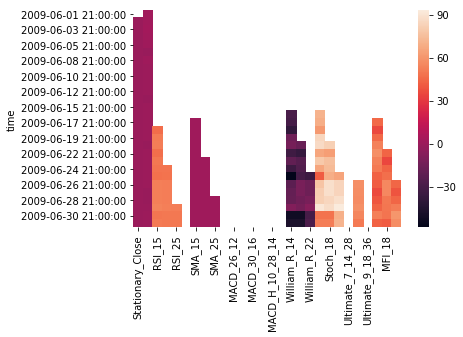

In [124]:
# One = dataframe block
sns.heatmap(one)

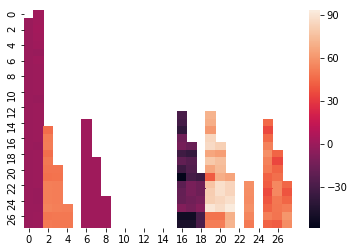

In [126]:
# test = np.array(df_window)
sns.heatmap(test)

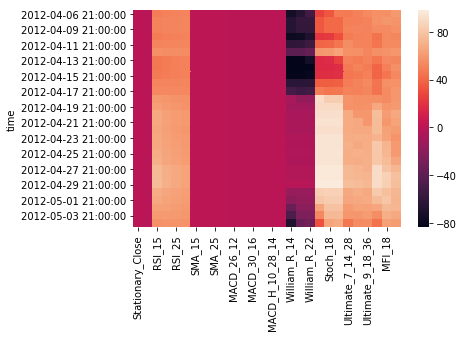

In [143]:
sns.heatmap(test_random_1)

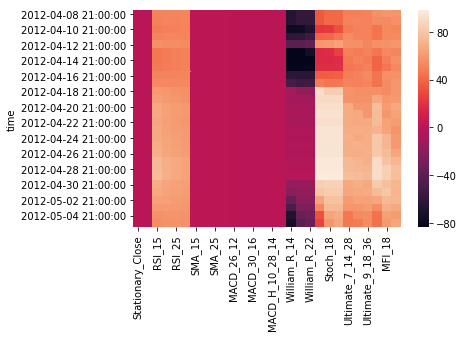

In [144]:
sns.heatmap(test_random_2)

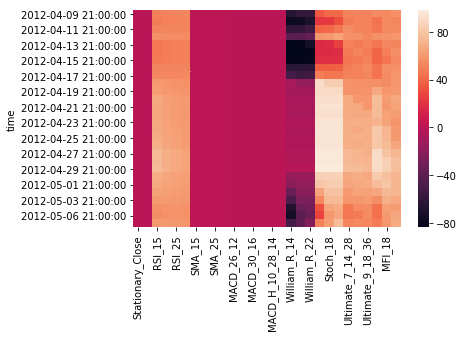

In [145]:
sns.heatmap(test_random_3)

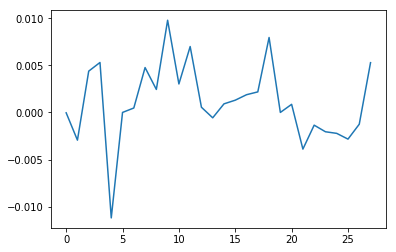

In [334]:
plt.plot(test_random_3['Stationary_Close'].values)

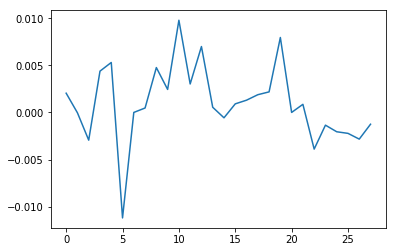

In [335]:
plt.plot(test_random_2['Stationary_Close'].values)

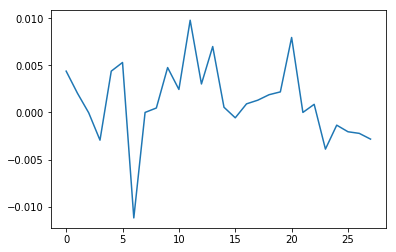

In [336]:
plt.plot(test_random_1['Stationary_Close'].values)

In [354]:
test_random_4 = df.iloc[:7]
test_random_5 = df.iloc[1:8]
test_random_6 = df.iloc[2:9]
test_random_7 = df.iloc[3:10]
test_random_8 = df.iloc[3:11]
test_random_9 = df.iloc[4:12]
test_random_10 = df.iloc[5:13]

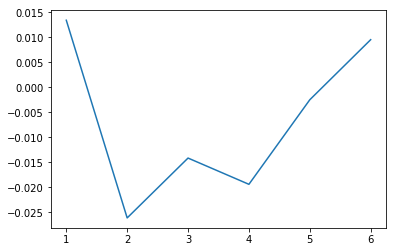

In [341]:
plt.plot(test_random_4['Stationary_Close'].values)

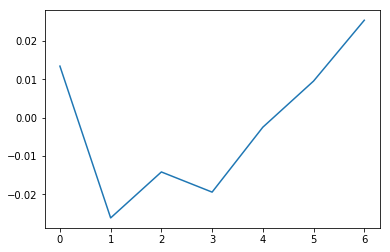

In [342]:
plt.plot(test_random_5['Stationary_Close'].values)

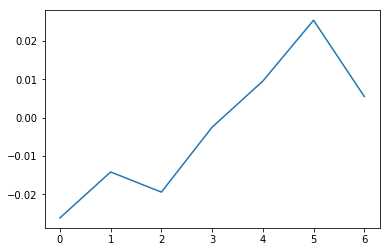

In [343]:
plt.plot(test_random_6['Stationary_Close'].values)

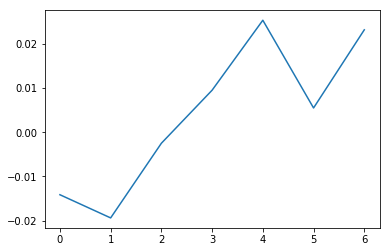

In [345]:
plt.plot(test_random_7['Stationary_Close'].values)

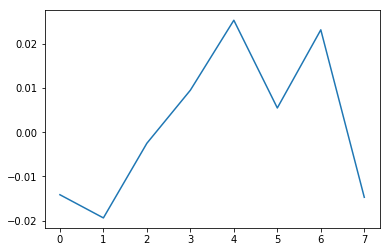

In [346]:
plt.plot(test_random_8['Stationary_Close'].values)

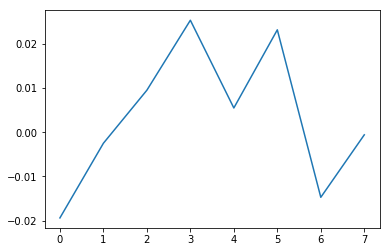

In [355]:
plt.plot(test_random_9['Stationary_Close'].values)

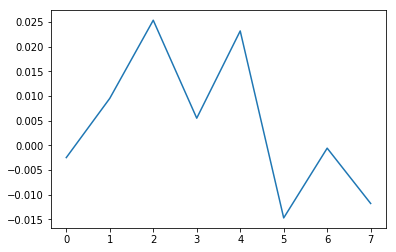

In [356]:
plt.plot(test_random_10['Stationary_Close'].values)